In [1]:
import numpy as np
#import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import scipy.sparse.linalg as sla
import numpy.linalg as la
import sys, os
import pickle
#import shapefile
import geopandas
#import rbf as RBF
import warnings

In [2]:
from FME import *

In [3]:
points = geopandas.read_file('data.gpkg',layer='points')
orientations = geopandas.read_file('data.gpkg',layer='orientations')
model_area = geopandas.read_file('data.gpkg',layer='bounding_box')

In [4]:
geom = model_area['geometry']#.shapes()
coords = np.array(geom[0].exterior.coords)#[0]
# print(geom['geometry'])
# coords = np.array(geom[0].points)
minz = -(np.max(coords[:,0])-np.min(coords[:,0]))/2.

In [5]:
boundary_points = np.zeros((2,3))
boundary_points[0,0] = np.min(coords[:,0])
boundary_points[0,1] = np.min(coords[:,1])
boundary_points[0,2] = minz
boundary_points[1,0] = np.max(coords[:,0])
boundary_points[1,1] = np.max(coords[:,1])
boundary_points[1,2] = -minz*0.1
mesh = TetMesh('NoddySingleFold',)
mesh.setup_mesh(boundary_points,nstep=1,n_tetra=50000,)
regionmanager = RegionManager(mesh)
cg = mesh.get_constant_gradient(region=mesh.regions['everywhere'],shape='square')
mesh.save()

In [6]:
fold_f1 = FoldFrame(mesh=mesh,region='everywhere',shape='square',name='Fold_f1')
for i, r in orientations.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_strike_and_dip([xy[0][0],xy[1][0],z],r['strike'],r['dip'],itype=r['itype'])
for i, r in points.iterrows():
    if r['type'] == 's1':
        xy = r['geometry'].xy
        z = 0
        if 'z' in r:
            z = r['z']
        fold_f1.add_point([xy[0][0],xy[1][0],z],r['value'],itype=r['itype'])

fold_f1.buildFrame(solver='chol')

Setting up interpolator with 1 value control points 
        7 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


/home/lgrose/.local/lib/python3.6/site-packages/FME-0.0.0-py3.6-linux-x86_64.egg/FME/dsi_interpolator.py:354: CholmodTypeConversionWarning: array contains 32 bit integers; but 64 bit integers are needed; slowing down due to converting
  factor = cholesky(self.AA.tocsc(),use_long=True)


Setting up interpolator with 1 value control points 
        7 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.100000


/home/lgrose/.local/lib/python3.6/site-packages/ipykernel_launcher.py:9: FutureWarning: set_value is deprecated and will be removed in a future release. Please use .at[] or .iat[] accessors instead
  if __name__ == '__main__':
/home/lgrose/.local/lib/python3.6/site-packages/pandas/core/indexing.py:362: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/home/lgrose/.local/lib/python3.6/site-packages/pandas/core/indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
/home/lgrose/

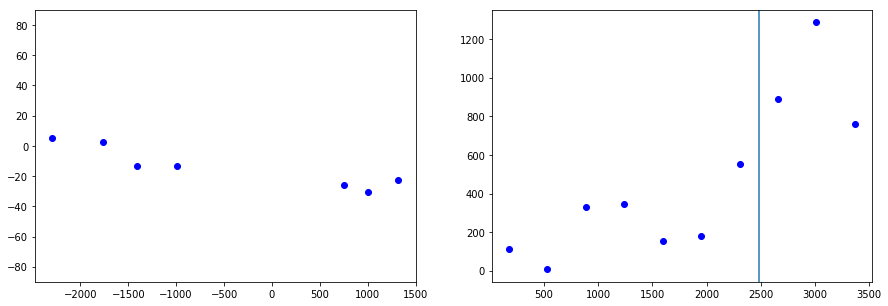

In [7]:
#from helper import strike_dip_vector
s0 = orientations[orientations['type'] == 's0']
nans = np.zeros(len(orientations))
nans[:] = np.nan
orientations['x'] = nans
orientations['y'] = nans
orientations['z'] = nans
for i,r in s0.iterrows():
    s0.set_value(i,'x',r['geometry'].xy[0][0])
    s0.set_value(i,'y',r['geometry'].xy[1][0])
    s0.set_value(i,'z',0)
xyz = s0.loc[:,['x','y','z']].as_matrix()
s0g = strike_dip_vector(s0.loc[:,'strike'],s0.loc[:,'dip'])
s0g /= np.linalg.norm(s0g,axis=1)[:,None]
l1 = fold_f1.calculate_intersection_lineation(np.hstack([xyz,s0g]))
far = fold_f1.calculate_fold_axis_rotation(np.hstack([xyz,l1]))                                        
s1 = fold_f1.get_gx(xyz,grad=False)
s1gy = fold_f1.get_gy(xyz,grad=False)

##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(s1gy,far,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
svario = s_variogram(s1gy,far)
svario.setup()
guess = svario.find_wavelengths()
ax[1].plot(svario.h,svario.var,'bo')
ax[1].axvline(guess[0])

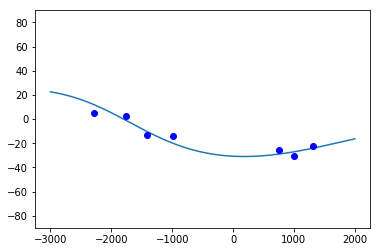

In [8]:
from scipy.interpolate import Rbf
far_tan = np.tan(np.deg2rad(far))
rbf_fold_axis = Rbf(s1gy,np.zeros(s1gy.shape),np.zeros(s1gy.shape),far_tan,function='gaussian',epsilon=guess[0],smooth=.1)
xi = np.linspace(-3000,2000,1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_axis(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1gy,far,'bo')
plt.ylim(-90,90)
def fold_axis_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_axis(x,np.zeros(x.shape),np.zeros(x.shape))))

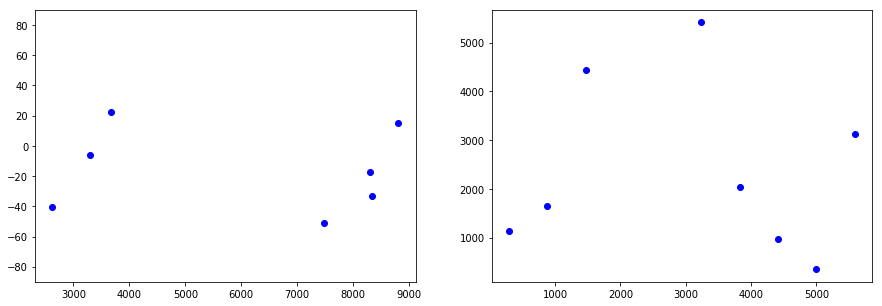

In [9]:
fold = FoldEvent(fold_f1,fold_axis_rotation,None)
axis = fold.get_fold_axis_orientation(xyz)
axis/=np.linalg.norm(axis,axis=1)[:,None]
flr = fold_f1.calculate_fold_limb_rotation(np.hstack([xyz,s0g]),axis=axis)
##quick figure
fig, ax = plt.subplots(1,2,figsize=(15,5))
ax[0].plot(s1,flr,'bo')
ax[0].set_ylim(-90,90)
#ax[0].ylim(-90,90)
svario = s_variogram(s1,flr)
svario.setup()
guess = svario.find_wavelengths()
ax[1].plot(svario.h,svario.var,'bo')
#ax[1].axvline(guess[1])
guess = np.array(guess)
guess[0] = 2500

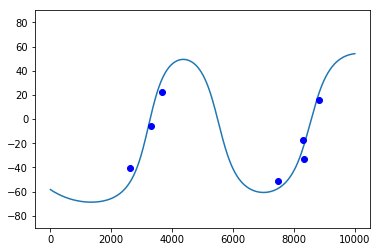

In [10]:
flr_tan = np.tan(np.deg2rad(flr))
rbf_fold_limb = Rbf(s1,np.zeros(s1.shape),np.zeros(s1.shape),flr_tan,function='gaussian',epsilon=guess[0],smooth=.05)
xi = np.linspace(0,10000,1000)
plt.plot(xi,np.rad2deg(np.arctan(rbf_fold_limb(xi,np.zeros(1000),np.zeros(1000)))))
plt.plot(s1,flr,'bo')
plt.ylim(-90,90)
def fold_limb_rotation(x):
    return np.rad2deg(np.arctan(rbf_fold_limb(x,np.zeros(x.shape),np.zeros(x.shape))))

In [11]:
#update the fold event to have a real fold_limb_rotation function
fold.fold_limb_rotation = fold_limb_rotation
const = DSIFoldConstraint(fold,mesh,shape='square') 
const.use_deformed_orientation_cnstrt(50.) 
const.use_fold_axis_cnstrt(3.) 
const.use_regularisation_cnstrt(10.) 
const.use_normalisation_cnstrt()

A, B, row, col = const.get_constraints()
deformed_orientation, fold_axis, dgz = fold.get_deformed_orientation(mesh.barycentre)
mesh.property_gradients['fold'] = deformed_orientation 
mesh.property_gradients['axis'] = fold_axis 
mesh.update_property('foldrot',fold_limb_rotation(mesh.properties[fold_f1.interpolators['gx'].propertyname]))

In [ ]:
stratigraphy = DSI(mesh,region='everywhere',shape='square',solver='chol')
stratigraphy.add_point([70.1,0.1,1.1],0.)
stratigraphy.setup_interpolator(cg=False,cgw=0.)
stratigraphy.A.extend(A)
stratigraphy.row.extend(row)
stratigraphy.col.extend(col)
stratigraphy.B+=B
stratigraphy.solve_system(solver='chol',clear=True)
mesh.update_property('strati',stratigraphy.c)

Setting up interpolator with 1 value control points 
        0 gradient control points and 0 tangent control points and 
        constant gradient regularization with a weight of 0.000000
